# An Analysis of Bicycle Accidents in Madrid

The present project is an attempt to analyze a real-world dataset, in order to practice data wrangling with the pandas library. It has been motivated by Jake VanderPlas' wonderful book *Python Data Science Handbook*, available for free in his GitHub page (https://github.com/jakevdp/PythonDataScienceHandbook).

Searching for interesting datasets I found the data webpage of the local government of Madrid, and specifically a dataset of the traffic accidents involving bicycles in this city, by year ([Accidentes de tráfico con implicación de bicicletas](https://datos.madrid.es/portal/site/egob/menuitem.c05c1f754a33a9fbe4b2e4b284f1a5a0/?vgnextoid=20f4a87ebb65b510VgnVCM1000001d4a900aRCRD&vgnextchannel=374512b9ace9f310VgnVCM100000171f5a0aRCRD&vgnextfmt=default)). I decided to analyze and try to get some insights from this raw data.

The use of bicycles is becoming more and more important in big cities like Madrid, specially for commuting purposes. Historically, people in Spain have not used the bicycle as much as the citizens of other countries such as Italy, Belgium or the Netherlands. However, this is changing due to the efforts of local governents to improve bicycle integration in traffic (e.g. special signaling and bicycle paths) and to create public rental services (e.g. BiciMAD). BiciMAD supplies 100% electric bikes and is available for all citizens and visitors to the city of Madrid. As of now, the service includes 1,560 electric bikes distributed among 123 stations.

In this short project, I first get the datasets of different years from the [data webpage](datos.madrid.es) of the local government of Madrid. Then, I perform some cleaning and preparing of the data in order to ease its analysis. Finally, I analyze the data and extract some interesting insights.

## Getting the Data
The first step in any data science project is getting the data. This section covers the simple data aquisition process followed in this project.
### Downloading the Datasets
Assuming the notebook is being executed from the *../madrid-biclycle-accidents/notebooks* directory, the following cell downloads the datasets for the 2010-2018 period and places them in the *../madrid-biclycle-accidents/datasets* directory. The datasets have been previously downloaded and are already included in the repository, so running this cell is optional.

In [ ]:
!mkdir ../datasets
%cd ../datasets
!curl -L -o dataset_#1.xlsx https://datos.madrid.es/egob/catalogo/300110-[1-17:2]-accidentes-bicicleta.xlsx
%cd ../notebooks

### Importing the Datasets with *Pandas*
We first proceed with the imports required for the project.

In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

Next, we read each of the excel datasets into separate pandas *DataFrames* and store them in a list. Then, we concat all the *DataFrames* in the list and show the first five rows with the head() method.

In [2]:
df_list = []
for i in range(9):
    curr_df = pd.read_excel("../datasets/dataset_" + str(2*i + 1) + ".xlsx")
    df_list.append(curr_df)
    
df = pd.concat(df_list, ignore_index=True)
df.head()

,FECHA,RANGO HORARIO,DIA SEMANA,DISTRITO,LUGAR ACCIDENTE,Nº,Nº PARTE,CPFA Granizo,CPFA Hielo,CPFA Lluvia,...,CPSV Hielo,CPSV Seca Y Limpia,Nº VICTIMAS *,TIPO ACCIDENTE,Tipo Vehiculo,TIPO PERSONA,SEXO,LESIVIDAD,Tramo Edad,* Nº VICTIMAS
0,2017-01-01,DE 6:00 A 6:59,DOMINGO,ARGANZUELA,CALLE DE TOLEDO NUM ...,120,2017/88,NO,NO,NO,...,NO,SI,1.0,CHOQUE CON OBJETO FIJO,BICICLETA,CONDUCTOR,MUJER,HG,DE 21 A 24 AÑOS,NaN
1,2017-01-02,DE 21:00 A 21:59,LUNES,SAN BLAS,CALLE DE MEQUINENZA NUM ...,14,2017/70,NO,NO,NO,...,NO,SI,1.0,CAÍDA BICICLETA,BICICLETA,CONDUCTOR,HOMBRE,HL,DE 25 A 29 AÑOS,NaN
2,2017-01-03,DE 19:00 A 19:59,MARTES,CENTRO,CALLE DE LA ESCALINATA NUM ...,8,2017/307,NO,NO,NO,...,NO,SI,1.0,CAÍDA BICICLETA,BICICLETA,CONDUCTOR,HOMBRE,HL,DE 18 A 20 AÑOS,NaN
3,2017-01-04,DE 21:00 A 21:59,MIERCOLES,CENTRO,CALLE DE LA CAVA DE SAN MIGUEL NUM ...,13,2017/124,NO,NO,NO,...,NO,NO,1.0,CAÍDA BICICLETA,BICICLETA,CONDUCTOR,HOMBRE,HL,DE 30 A 34 ANOS,NaN
4,2017-01-05,DE 8:00 A 8:59,JUEVES,MONCLOA-ARAVACA,PUENTE DE LOS FRANCESES ...,0,2017/206,NO,NO,NO,...,NO,NO,1.0,CAÍDA BICICLETA,BICICLETA,CONDUCTOR,HOMBRE,HL,DE 45 A 49 AÑOS,NaN


Let's see an overview of the data using the info() method.

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5524 entries, 0 to 5523
Data columns (total 27 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   FECHA               5524 non-null   datetime64[ns]
 1   RANGO HORARIO       5524 non-null   object        
 2   DIA SEMANA          5524 non-null   object        
 3   DISTRITO            5524 non-null   object        
 4   LUGAR ACCIDENTE     5524 non-null   object        
 5   Nº                  5524 non-null   object        
 6   Nº PARTE            5524 non-null   object        
 7   CPFA Granizo        5524 non-null   object        
 8   CPFA Hielo          5524 non-null   object        
 9   CPFA Lluvia         5524 non-null   object        
 10  CPFA Niebla         5524 non-null   object        
 11  CPFA Seco           5524 non-null   object        
 12  CPFA Nieve          5524 non-null   object        
 13  CPSV Mojada         5524 non-null   object      

There is an entry for every person involved in an accident, so we can see there have been 5524 people involved in bicycle accidents between 2010 and 2018!

## Cleaning and Preparing the Data
The next step in a data science project is cleaning and preparing the data. This section covers the translation, the handling of missing values and the rearanging of the *DataFrame* to analyze the data easier. 
### Translating the *DataFrame*
First, let's see the columns of the *DataFrame*.

In [4]:
df.columns

Index(['FECHA', 'RANGO HORARIO', 'DIA SEMANA', 'DISTRITO', 'LUGAR ACCIDENTE',
       'Nº', 'Nº PARTE', 'CPFA Granizo', 'CPFA Hielo', 'CPFA Lluvia',
       'CPFA Niebla', 'CPFA Seco', 'CPFA Nieve', 'CPSV Mojada', 'CPSV Aceite',
       'CPSV Barro', 'CPSV Grava Suelta', 'CPSV Hielo', 'CPSV Seca Y Limpia',
       'Nº VICTIMAS *', 'TIPO ACCIDENTE', 'Tipo Vehiculo', 'TIPO PERSONA',
       'SEXO', 'LESIVIDAD', 'Tramo Edad', '* Nº VICTIMAS'],
      dtype='object')

Now we translate the columns from spanish.

In [5]:
eng_cols = ["Date", "Hour Range", "Day of Week", "District", "Location", "No.", "Report No.", "Weather: Hail", "Weather: Ice","Weather: Rain", "Weather: Fog", "Weather: Dry", "Weather: Snow", "Road: Wet", "Road: Oil", "Road: Mud", "Road: Gravel", "Road: Ice", "Road: Dry and clean", "Victims Involved", "Accident Type", "Vehicle Type", "Person Type", "Gender", "Harmfulness", "Age Range", "* Victims"]

df.columns = eng_cols

Some colums don't convey much info. For example, there are no entries with a *Vehicle Type* attribute different to *BICICLETA* (Bicycle).

In [6]:
df.loc[df["Vehicle Type"].str.strip() != "BICICLETA", "Date"].count()

0

So let's drop unnecessary information (attributes).

In [7]:
df.drop(columns=["Day of Week", "Report No.", "Weather: Hail", "Vehicle Type", "* Victims"], inplace=True)
df.columns

Index(['Date', 'Hour Range', 'District', 'Location', 'No.', 'Weather: Ice',
       'Weather: Rain', 'Weather: Fog', 'Weather: Dry', 'Weather: Snow',
       'Road: Wet', 'Road: Oil', 'Road: Mud', 'Road: Gravel', 'Road: Ice',
       'Road: Dry and clean', 'Victims Involved', 'Accident Type',
       'Person Type', 'Gender', 'Harmfulness', 'Age Range'],
      dtype='object')

Now let's translate the values of the categorical attributes. We must first know the unique values of each of the attributes we want to translate.

In [8]:
for _, series in df.loc[:, "Weather: Ice":"Age Range"].items():
    print(f"{series.name}: {series.unique()}")

Weather: Ice: ['NO' 'SI']
Weather: Rain: ['NO' 'SI']
Weather: Fog: ['NO' 'SI']
Weather: Dry: ['SI' 'NO']
Weather: Snow: ['NO' 'SI']
Road: Wet: ['NO' 'SI']
Road: Oil: ['NO' 'SI']
Road: Mud: ['NO' 'SI']
Road: Gravel: ['NO' 'SI']
Road: Ice: ['NO' 'SI']
Road: Dry and clean: ['SI' 'NO']
Victims Involved: [ 1.  2.  3. nan  6.  5.  4.]
Accident Type: ['CHOQUE CON OBJETO FIJO                  '
 'CAÍDA BICICLETA                         '
 'ATROPELLO                               '
 'COLISIÓN DOBLE                          '
 'CAÍDA MOTOCICLETA                       '
 'CAÍDA VIAJERO BUS                       '
 'COLISIÓN MÚLTIPLE                       '
 'OTRAS CAUSAS                            '
 'CAÍDA CICLOMOTOR                        '
 'VUELCO                                  ']
Person Type: ['CONDUCTOR' 'VIAJERO                                 '
 'TESTIGO                                 ']
Gender: ['MUJER' 'HOMBRE' 'NO ASIGNADO']
Harmfulness: ['HG                                      '
 

Some attributes have trailing space in their values. Let's strip this strings.

In [9]:
df.loc[:, "Accident Type":"Age Range"] = df.loc[:, "Accident Type":"Age Range"].transform(lambda x: x.str.strip())

Now we create translation dictionaries in order to map them to each attribute (column).

In [10]:
# Yes/No dict for the first columns
yn_dict = {"SI": "Yes", "NO": "No"}

# Translate the first columns
for column in df.loc[:, "Weather: Ice":"Road: Dry and clean"].columns:
    df.replace({column: yn_dict}, inplace=True)

# English translation for the rest of the columns
acc_type_eng = ["Crash with static object", "Fall off bicycle", "Run over", "Double collision", "Fall off motorcycle", "Bus passenger fall", "Multiple collision", "Other causes", "Fall off moped", "Overturn"]
person_type_eng = ["Driver", "Accompanying", "Witness"]
gender_eng = ["W", "M", "Not assigned"]
harmfulness_eng = ["Seriously injured", "Slightly injured", "Uninjured", "Not assigned", "Killed"]
age_range_eng = ["21-24", "25-29", "18-20", "30-34", "45-49", "65-69", "35-39", "55-59", "50-54", "40-44", "10-14", "15-17", "06-09", "60-64", "00-05", "75+", "Unknown", "70-74"]
eng_list = [acc_type_eng, person_type_eng, gender_eng, harmfulness_eng, age_range_eng]

# Create the translation dictionaries and translate the rest of the columns
for (_, series), eng in zip(df.loc[:, "Accident Type":"Age Range"].items(), eng_list):
    esp = series.unique()
    dict = {k: v for k, v in zip(esp, eng)}
    df.replace({series.name: dict}, inplace=True)

# Show head
df.head()

,Date,Hour Range,District,Location,No.,Weather: Ice,Weather: Rain,Weather: Fog,Weather: Dry,Weather: Snow,...,Road: Mud,Road: Gravel,Road: Ice,Road: Dry and clean,Victims Involved,Accident Type,Person Type,Gender,Harmfulness,Age Range
0,2017-01-01,DE 6:00 A 6:59,ARGANZUELA,CALLE DE TOLEDO NUM ...,120,No,No,No,Yes,No,...,No,No,No,Yes,1.0,Crash with static object,Driver,W,Seriously injured,21-24
1,2017-01-02,DE 21:00 A 21:59,SAN BLAS,CALLE DE MEQUINENZA NUM ...,14,No,No,No,Yes,No,...,No,No,No,Yes,1.0,Fall off bicycle,Driver,M,Slightly injured,25-29
2,2017-01-03,DE 19:00 A 19:59,CENTRO,CALLE DE LA ESCALINATA NUM ...,8,No,No,No,Yes,No,...,No,No,No,Yes,1.0,Fall off bicycle,Driver,M,Slightly injured,18-20
3,2017-01-04,DE 21:00 A 21:59,CENTRO,CALLE DE LA CAVA DE SAN MIGUEL NUM ...,13,No,No,Yes,No,No,...,No,No,No,No,1.0,Fall off bicycle,Driver,M,Slightly injured,30-34
4,2017-01-05,DE 8:00 A 8:59,MONCLOA-ARAVACA,PUENTE DE LOS FRANCESES ...,0,No,No,Yes,No,No,...,No,No,No,No,1.0,Fall off bicycle,Driver,M,Slightly injured,45-49


### Handling Missing Values
Let's check for attributes with null values.

In [11]:
df.isnull().any()

Date                   False
Hour Range             False
District               False
Location               False
No.                    False
Weather: Ice           False
Weather: Rain          False
Weather: Fog           False
Weather: Dry           False
Weather: Snow          False
Road: Wet              False
Road: Oil              False
Road: Mud              False
Road: Gravel           False
Road: Ice              False
Road: Dry and clean    False
Victims Involved        True
Accident Type          False
Person Type            False
Gender                 False
Harmfulness            False
Age Range              False
dtype: bool

There is only null values in the *Victims* column. Let's see how many entries have a null value in this column.

In [12]:
df["Victims Involved"].isnull().sum()

700

This is a significant amount of data ($\approx 13$%), so we'll fill the null values. Let's explore the *Person Type* attribute of the entries with null values.

In [13]:
df[df["Victims Involved"].isnull()].groupby("Person Type")["Date"].count()

Person Type
Accompanying      5
Driver          694
Witness           1
Name: Date, dtype: int64

For the sake of simplicity, let's suppose drivers were the only ones injured in their accidents, and accompanyings were involved in accidents with two victims (i.e the driver was injured too). We'll discard the witness as he probably only reported a crash but wasn't involved in it.

In [14]:

df.loc[df["Person Type"] == "Driver", "Victims Involved"] = df.loc[df["Person Type"] == "Driver", "Victims Involved"].fillna(1)
df.loc[df["Person Type"] == "Accompanying", "Victims Involved"] = df.loc[df["Person Type"] == "Accompanying", "Victims Involved"].fillna(2)
df.drop(index=df.index[df["Person Type"] == "Witness"], inplace=True)

### Rearanging the *DataFrame*
Let's rearange the *DataFrame* in order to make it easer to manipulate and analyze.
#### Composing the *Weather* and *Road Condition* Columns
It would be convenient to compose the *Weather* and *Road Condition* data so it is contained only in two columns (instead of Yes/No for each of the possible weather and condition). 

In [15]:
df["Weather"] = df.apply(lambda row: row.iloc[5:10][row.iloc[5:10] == "Yes"].index[0].split(" ")[-1], axis="columns")
df["Road Condition"] = df.apply(lambda row: row.iloc[10:16][row.iloc[10:16] == "Yes"].index[0].split(" ", maxsplit=1)[-1], axis="columns")

IndexError: index 0 is out of bounds for axis 0 with size 0

The second statement throws an error because thera are entries with no *Road Condition* assigned.

In [16]:
df.query("`Road: Wet` == 'No' & `Road: Oil` == 'No' & `Road: Mud` == 'No' & `Road: Gravel` == 'No' & `Road: Ice` == 'No' & `Road: Dry and clean` == 'No'")["Date"].count()

78

Let's suppose those days the road was dry and clean.

In [17]:
df.loc[(df["Road: Wet"] == "No") & (df["Road: Oil"] == "No") & (df["Road: Mud"] == "No") & (df["Road: Gravel"] == "No") & (df["Road: Ice"] == "No") & (df["Road: Dry and clean"] == "No"), "Road: Dry and clean"] = "Yes"
df["Road Condition"] = df.apply(lambda row: row.iloc[10:16][row.iloc[10:16] == "Yes"].index[0].split(" ", maxsplit=1)[-1], axis="columns")

Now we can drop this columns.

In [18]:
df.drop(columns=df.loc[:, "Weather: Ice":"Road: Dry and clean"].columns, inplace=True)

#### Creating a *PeriodIndex*
We can see the entries are catalogued in periods of one hour. It'd be handy to create an *PeriodIndex* to access the data easier. The *Date* column is already in datetime64 type.

In [19]:
df["Date"].head()

0   2017-01-01
1   2017-01-02
2   2017-01-03
3   2017-01-04
4   2017-01-05
Name: Date, dtype: datetime64[ns]

However, the *Hour Range* column needs to be formatted. Lets extract the starting hour of the range and rename the column to *Hour*.

In [20]:
df["Hour Range"].head()

0      DE 6:00 A 6:59
1    DE 21:00 A 21:59
2    DE 19:00 A 19:59
3    DE 21:00 A 21:59
4      DE 8:00 A 8:59
Name: Hour Range, dtype: object

In [21]:
df["Hour Range"] = df["Hour Range"].str.extract("([0-9]+)").astype("uint8")
df.rename(columns={"Hour Range": "Hour"}, inplace=True)
df["Hour"].head()

0     6
1    21
2    19
3    21
4     8
Name: Hour, dtype: uint8

Now, we create a *DatetimeIndex* from the *Date* column in order to access its attributes separately (year, month, and day).

In [22]:
date_index = pd.DatetimeIndex(df["Date"])
date_index

DatetimeIndex(['2017-01-01', '2017-01-02', '2017-01-03', '2017-01-04',
               '2017-01-05', '2017-01-05', '2017-01-05', '2017-01-05',
               '2017-01-06', '2017-01-06',
               ...
               '2010-12-05', '2010-12-11', '2010-12-11', '2010-12-12',
               '2010-12-19', '2010-12-20', '2010-12-20', '2010-12-22',
               '2010-12-23', '2010-12-27'],
              dtype='datetime64[ns]', name='Date', length=5522, freq=None)

Next, we create a *PeriodIndex* adding the hour attribute from the *Hour* column and we set it as the *DataFrame*'s index.

In [23]:
period_index = pd.PeriodIndex(year=date_index.year.values, month=date_index.month.values, day=date_index.day.values, hour=df["Hour"], freq="H")
df.index = period_index
df.index

PeriodIndex(['2017-01-01 06:00', '2017-01-02 21:00', '2017-01-03 19:00',
             '2017-01-04 21:00', '2017-01-05 08:00', '2017-01-05 12:00',
             '2017-01-05 14:00', '2017-01-05 17:00', '2017-01-06 11:00',
             '2017-01-06 17:00',
             ...
             '2010-12-05 18:00', '2010-12-11 04:00', '2010-12-11 18:00',
             '2010-12-12 11:00', '2010-12-19 12:00', '2010-12-20 11:00',
             '2010-12-20 16:00', '2010-12-22 08:00', '2010-12-23 09:00',
             '2010-12-27 11:00'],
            dtype='period[H]', length=5522, freq='H')

Finally, we drop the now unecessary columns and sort the index by date.

In [24]:
df.drop(columns=["Date", "Hour"], inplace=True)
df.sort_index(inplace=True)

## Analyzing the Data
The time has come! We have all the data nicely arranged and ready to be analyzed. Let's start by setting up *matplotlib*'s style and default figure size.

In [25]:
plt.style.use("bmh")
mpl.rc("figure", figsize=(8, 6)) 

Now everything is ready to start getting insights and visualizing the data.
### Evolution of People Involved in Bicycle Accidents (2010-2018)
First of all, we'll focus on the evolution of people involved in bicycle accidents between 2010 and 2018.
#### Yearly Victim Count 
Let's count the total victims per year.

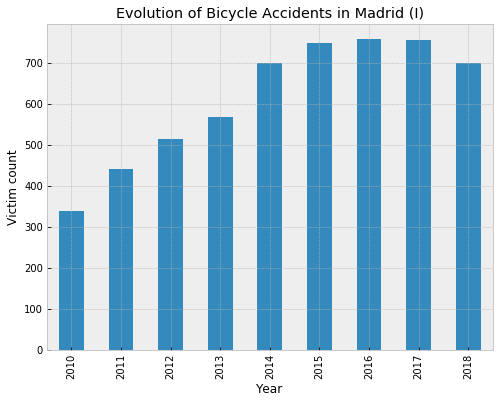

In [26]:
# Count victims per year
vict_per_year = df["District"].resample("A").count()
# Plot the data
fig = plt.figure()
ax = plt.axes()
ax.set(title="Evolution of Bicycle Accidents in Madrid (I)", xlabel="Year", ylabel="Victim count")
vict_per_year.plot(ax=ax, kind="bar")


We can see the number of victims linearly increased in the first five years, and then it remained constant in the next two. This is probably due to the increase of bicycle use in the city of Madrid during these period. In 2018, however, the victim count decreased by approximately 60 people, possibly because of improvements in signaling and bicycle paths promoted by the local government.

#### Monthly Victim Count

Now, let's zoom in a bit and analyze the evolution of people involved in accidents per month.

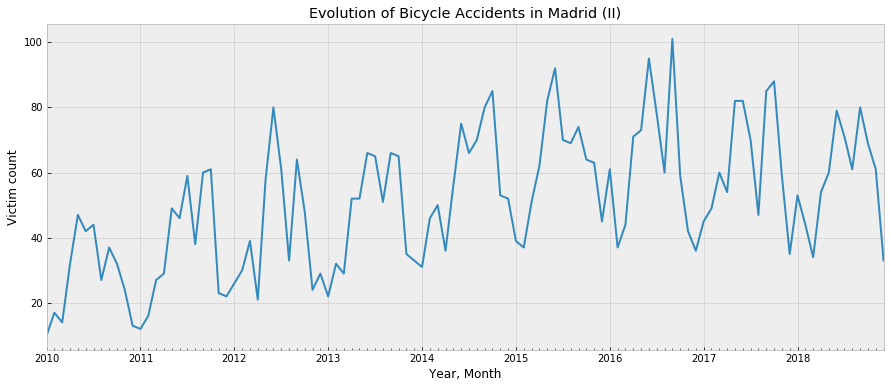

In [27]:
# Count the victims per month
vict_per_month = df["District"].resample("M").count()
# Plot data
fig = plt.figure(figsize=(15, 6))
ax = plt.axes()
ax.set(title="Evolution of Bicycle Accidents in Madrid (II)", xlabel="Year, Month", ylabel="Victim count")
vict_per_month.plot(ax=ax)
# Format the x ticks
ax.xaxis.set_minor_locator(plt.MultipleLocator())

This graph gives an overall view of the dataset.
### Rolling Average
Sometimes it's useful to perform a rolling average on the data to enhance the visuzalization. Let's count the victims per day and visualize a 15-day rolling average of the victim count. 

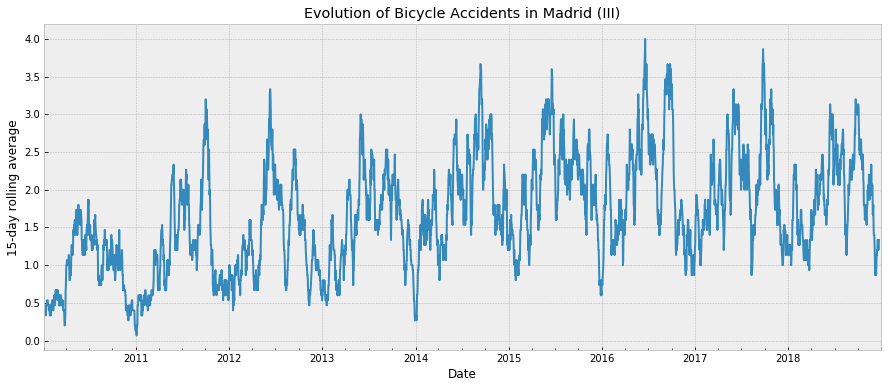

In [28]:
# Count victims per day
vict_per_day = df["District"].resample("D").count()
# Compute a 15-day rolling average and plot the data
fig = plt.figure(figsize=(15, 6))
ax = plt.axes()
ax.set(title="Evolution of Bicycle Accidents in Madrid (III)", xlabel="Date", ylabel="15-day rolling average")
vict_per_day.rolling(15, center=True).mean().plot(ax=ax)


The result is jagged, so we'll try to smooth the graph with a gaussian window.

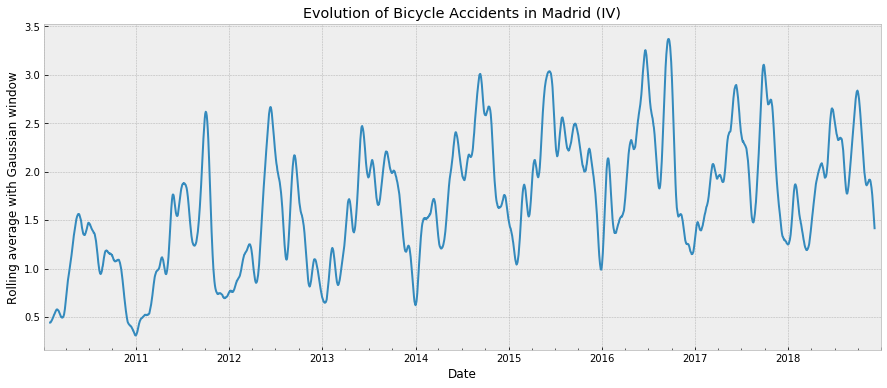

In [29]:
# Compute a 15-day rolling average and plot the data
fig = plt.figure(figsize=(15, 6))
ax = plt.axes()
ax.set(title="Evolution of Bicycle Accidents in Madrid (IV)", xlabel="Date", ylabel="Rolling average with Gaussian window")
vict_per_day.rolling(50, center=True, win_type="gaussian").mean(std=10).plot(ax=ax)

There are obvius seasonal trends, so let's try to analyze these.
#### Average Monthly Victims
Let's analyze the average monthly people involved over the course of a year.

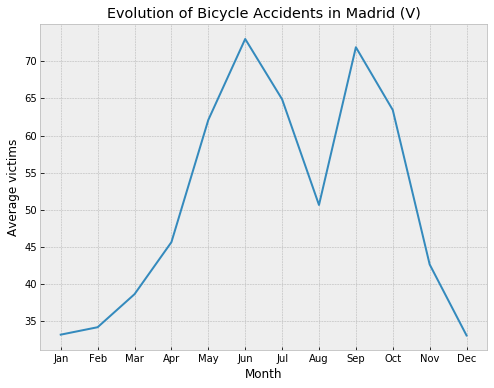

In [30]:
# Compute the monthly avg
avg_by_month = vict_per_month.groupby(vict_per_month.index.month).mean()
# Plot the data
fig = plt.figure()
ax = plt.axes()
ax.set(title="Evolution of Bicycle Accidents in Madrid (V)", xlabel="Month", ylabel="Average victims")
avg_by_month.plot(ax=ax)
# Format the x ticks
months = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]
ax.xaxis.set_major_locator(plt.FixedLocator([i for i in range(1, 13)]))
ax.xaxis.set_major_formatter(plt.FixedFormatter(months))
plt.show()


We can see the victim count increases along with the weather improvement until June. Then, it decreases significantly during summer, probably due to people leaving Madrid on holiday. In september it comes up again together with the reincorporation to work or school, and then it decreases together with the arrival of bad weather. 

#### Average Hourly Victims
This time let's explore the trend of victims during the course of a day.

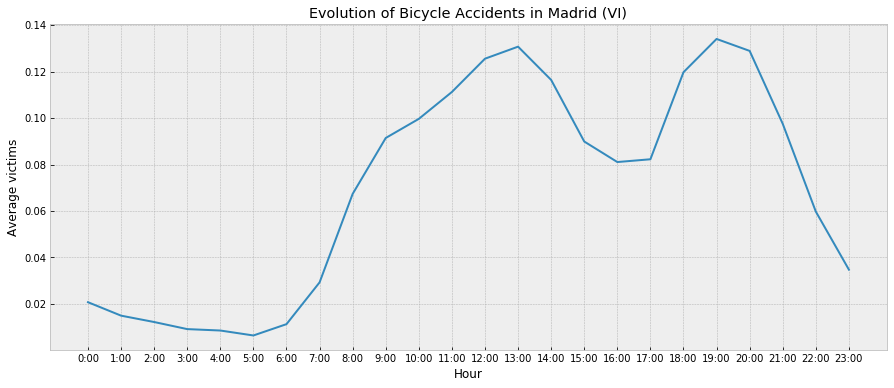

In [31]:
# Compute the hourly avg
vict_per_hour = df["District"].resample("H").count()
avg_by_hour = vict_per_hour.groupby(vict_per_hour.index.hour).mean()
# Plot the data
fig = plt.figure(figsize=(15, 6))
ax = plt.axes()
ax.set(title="Evolution of Bicycle Accidents in Madrid (VI)", xlabel="Hour", ylabel="Average victims")
avg_by_hour.plot(ax=ax)
# Format the x ticks
hours = [str(i) + ":00" for i in range(24)]
ax.xaxis.set_major_locator(plt.FixedLocator([i for i in range(24)]))
ax.xaxis.set_major_formatter(plt.FixedFormatter(hours))
plt.show()


This information would be more useful if we further split the data between weekdays and weekends, so let's perform this grouping.

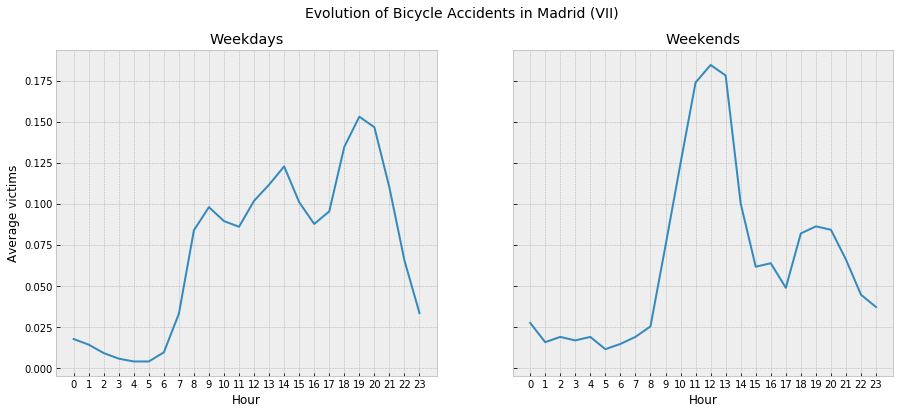

In [32]:
# Compute avg victims per hour depending if weekday/weekend
weekend = np.where(vict_per_hour.index.weekday < 5, "Weekday", "Weekend")
avg_by_hour = vict_per_hour.groupby([weekend, vict_per_hour.index.hour]).mean()
# Plot the data
fig, axs = plt.subplots(1, 2, figsize=(15, 6), sharey=True)
fig.suptitle("Evolution of Bicycle Accidents in Madrid (VII)", fontsize=14)
axs[0].set(title="Weekdays", xlabel="Hour", ylabel="Average victims")
axs[1].set(title="Weekends", xlabel="Hour")
avg_by_hour["Weekday"].plot(ax=axs[0])
avg_by_hour["Weekend"].plot(ax=axs[1])
# Format the x ticks
axs[0].xaxis.set_major_locator(plt.FixedLocator([i for i in range(24)]))
axs[1].xaxis.set_major_locator(plt.FixedLocator([i for i in range(24)]))
plt.show()



We can see during weekdays there is a peak in the victim count at 8:00-9:00 (rush hour), 14:00 (some people commuting?) and 19:00-20:00 (people comutting and ciclyng for leisure?). The trend is quite different for weekends, as expected. Accidents occur mainly between 12:00 and 14:00 (people ciclyng for leisure?) and to a lesser extent between 18:00 and 20:00. 
### Analysis of the *Weather* and *Road Condition*
Let's now have a look at the *Weather* and *Road Condition* at the time of the accidents. We'll compute the percentage of each *Weather*-*Road Condition* combination.

In [33]:
conds = df.pivot_table("District", index="Weather", columns="Road Condition", aggfunc="count")/df.shape[0]*100
conds.fillna(0, inplace=True)
conds


Road Condition,Dry and clean,Gravel,Ice,Mud,Oil,Wet
Weather,,,,,,
Dry,91.072075,1.44875,0.018109,0.144875,0.144875,1.829047
Fog,0.018109,0.00000,0.018109,0.000000,0.000000,0.181094
Ice,0.000000,0.00000,0.090547,0.000000,0.000000,0.000000
Rain,0.108656,0.00000,0.000000,0.000000,0.000000,4.925752


Let's vizualize only the *Road Condition* attribute in a bar plot, and add anotations for the least frequent *Road Condition* values in order to see their percentages clearly.

Text(4, 2, '0.14%')

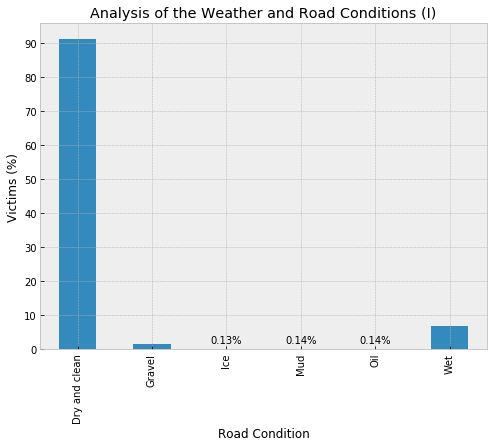

In [34]:
#Plot the data
fig = plt.figure()
ax = plt.axes()
ax.set(title="Analysis of the Weather and Road Condition (I)", ylabel="Victims (%)")
conds.sum(axis="index").plot(ax=ax, kind="bar")
# Format y ticks
ax.yaxis.set_major_locator(plt.MultipleLocator(10))
# Add anotations for categories with low percentage
ax.text(2, 2, "0.13%", ha="center")
ax.text(3, 2, "0.14%", ha="center")
ax.text(4, 2, "0.14%", ha="center")

We can see the most frequent *Road Condition* is by far *Dry and clean* followed by *Wet*.

### Analyzing the *Accident Type*

We'll now try to gain insights in the *Accident Type*.

#### An Overview of the *Accident Type* Attribute

First, let's compute and visualize the percentages of each type.

Text(8, 1, '0.02%')

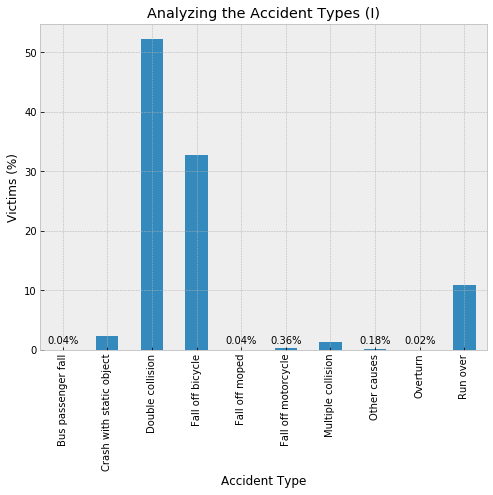

In [35]:
# Compute percentage of victims per accident type
acc_types = df.groupby("Accident Type")["District"].count()/df.shape[0]*100
# Plot the data
fig = plt.figure()
ax = plt.axes()
ax.set(title="Analyzing the Accident Types (I)", ylabel="Victims (%)")
acc_types.plot(ax=ax, kind="bar")
# Add anotations for categories with low percentage
ax.text(0, 1, "0.04%", ha="center")
ax.text(4, 1, "0.04%", ha="center")
ax.text(5, 1, "0.36%", ha="center")
ax.text(7, 1, "0.18%", ha="center")
ax.text(8, 1, "0.02%", ha="center")

*Double collision* is the cause of more than half of the accidents. *Fall off bicycle* and to a lesser extent *Run over* are also the frequent *Accident Type*.

#### Relationship Between the *Accident Type* and the *Age Range*

lets explore the relationshipa blabla, drop the least frequent etc.

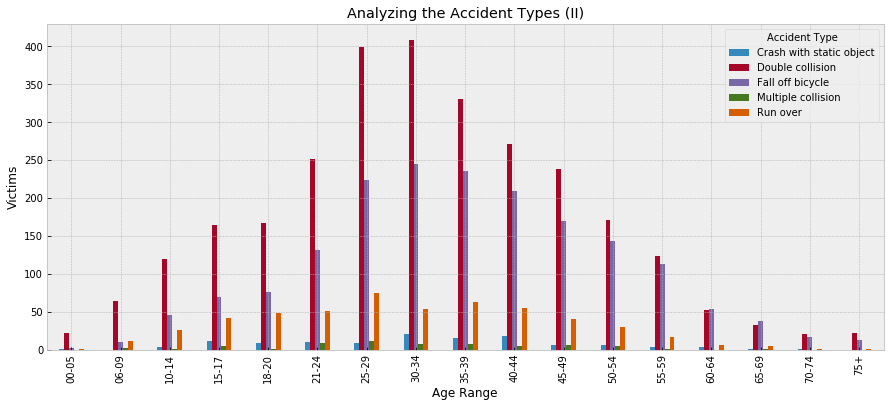

In [36]:
# Compute total victims per age range and accident type
type_and_age = df.pivot_table("District", index="Age Range", columns="Accident Type", aggfunc="count")
# Drop unknown age range and rare accidents
type_and_age.drop(index="Unknown", columns=["Bus passenger fall", "Fall off moped", "Fall off motorcycle", "Other causes", "Overturn"], inplace=True)
type_and_age.sort_index(inplace=True)
# Plot the data
fig = plt.figure(figsize=(15, 6))
ax = plt.axes()
ax.set(title="Analyzing the Accident Types (II)", ylabel="Victims")
type_and_age.plot(ax=ax, kind="bar")

Comment data
### Exploring the *Harmfulness* of the Accidents
intro bla bla
#### An Overview of the *Harmfulness*
overviweew b lala

Text(0, 2, '0.16%')

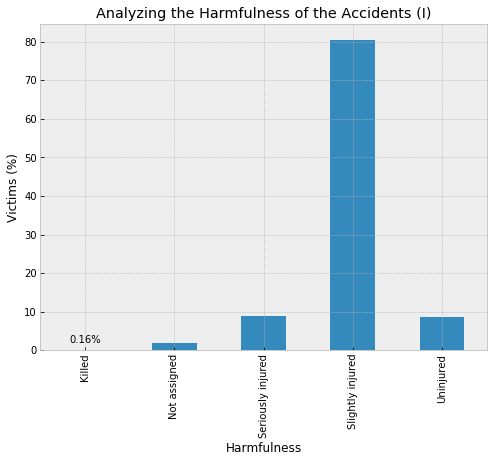

In [37]:
# Compute percentage of victims per harmfulness
harmfulness = df.groupby("Harmfulness")["District"].count()/df.shape[0]*100
# Plot the data
fig = plt.figure()
ax = plt.axes()
ax.set(title="Analyzing the Harmfulness of the Accidents (I)", ylabel="Victims (%)")
harmfulness.plot(ax=ax, kind="bar")
# Add anotation for the killed category
ax.text(0, 2, "0.16%", ha="center")

#### Relationship Between the *Harmfulness* and the *Gender*
interesting, baldad

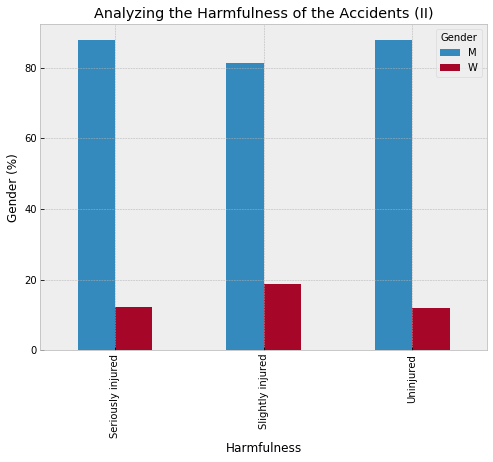

In [38]:
# Compute total victims per harmfulness and gender
harm_and_gender = df.pivot_table("District", index="Harmfulness", columns="Gender", aggfunc="count")
# Drop killed and not assigned category
harm_and_gender.drop(index=["Killed", "Not assigned"], columns="Not assigned", inplace=True)
# Compute percentage per gender
harm_and_gender = harm_and_gender.apply(lambda col: col/harm_and_gender.sum(axis="columns")*100, axis="index")
# Plot the data
fig = plt.figure()
ax = plt.axes()
ax.set(title="Analyzing the Harmfulness of the Accidents (II)", ylabel="Gender (%)")
harm_and_gender.plot(ax=ax, kind="bar")

## Conclusion
Give a conclusion.